# ASUM

In [1]:
import os
import re

import numpy as np
import pandas as pd

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from reviews.config import processed_data_dir, asum_model_path, asum_input_dir, asum_output_dir
from reviews.models import ASUM

## Generate Input Data

In [4]:
# load tokens
reviews_df = pd.read_json(processed_data_dir / "reviews_lemmatization.json.gz")

# load vocabulary
vocabulary = np.load(asum_input_dir / "vocabulary.npy", allow_pickle=True).item()

In [5]:
with open(asum_input_dir / "WordList.txt", "w") as f:
    for word in vocabulary:
        f.write(f"{word}\n")

In [6]:
sentence_list = asum_input_dir / "BagOfSentences.txt"

if os.path.exists(sentence_list):
    os.remove(sentence_list)

with open(sentence_list, "a") as f:
    for doc in reviews_df["tokens"]:
        f.write(f"{len(doc)}\n")
        for tokens in doc:
            indexes = " ".join([str(vocabulary[t]) for t in tokens])
            f.write(f"{indexes}\n")

## Run

In [ ]:
alpha = 0.1
beta = [0.001, 0.1, 0]
gamma = [1, 1]
n_topics = 5
iterations = 1000

model = ASUM(asum_model_path, asum_input_dir, asum_output_dir)
model.estimate(alpha, beta, gamma, n_topics, iterations)

## Analysis

In [8]:
filename_prefix = f"STO2-T{n_topics}-S2(2)-A{alpha}-B{','.join([f'{float(x)}' for x in beta])}-G{','.join([f'{float(x):.1f}' for x in gamma])}-I{iterations}"

In [9]:
df = pd.read_csv(asum_output_dir / f"{filename_prefix}-ProbWords.csv")


def map_topic_sentiment(column_name):
    if "Unnamed" in column_name:
        return None

    values = column_name.split("-")
    return {
        "sentiment": int(values[0][1]),
        "topic": int(values[1][1]),
        "colname": column_name,
    }


columns = df.columns.map(map_topic_sentiment)

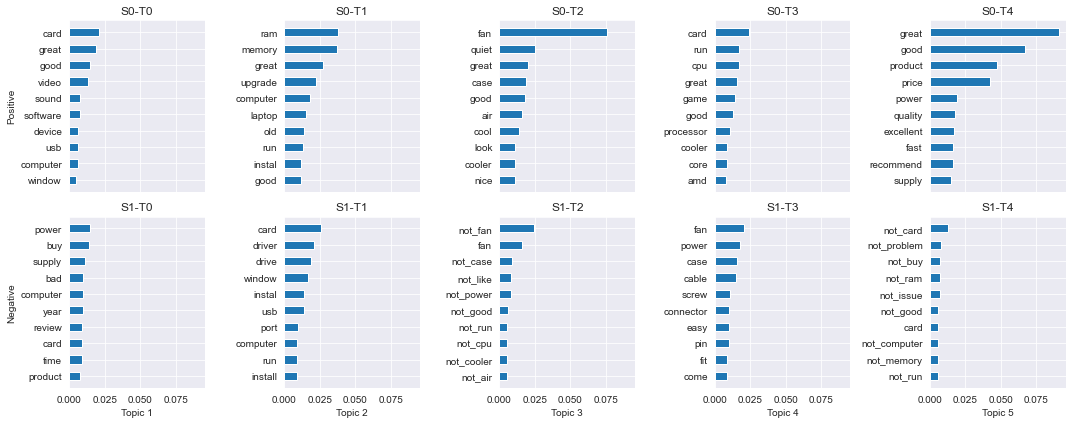

In [10]:
def get_word_weight(text):
    match = re.match("(\w+)\s+\((.*?)\)", text)
    word, weight = match.groups()
    return word, float(weight)


n_topics = 5
n_top_words = 10

fig, axes = plt.subplots(2, n_topics, figsize=(15, 6), sharex="all")
axes = axes.flatten()

for idx, item in enumerate(columns):
    if item is None:
        continue

    ax = axes[idx]
    words = df[item["colname"]][:n_top_words]
    weights = list(map(list, zip(*words.map(get_word_weight))))

    weights = pd.DataFrame({"names": weights[0], "weights": weights[1]})
    weights.sort_values("weights", inplace=True)

    ax.barh(weights["names"], weights["weights"], height=0.5)
    ax.set_title(item["colname"])

    if idx > n_topics - 1:
        ax.set_xlabel(f"Topic {item['topic'] + 1}")

    if idx == 0 or idx == n_topics:
        ax.set_ylabel("Positive" if item["sentiment"] == 0 else "Negative")
fig.tight_layout()

<AxesSubplot:xlabel='value', ylabel='word'>

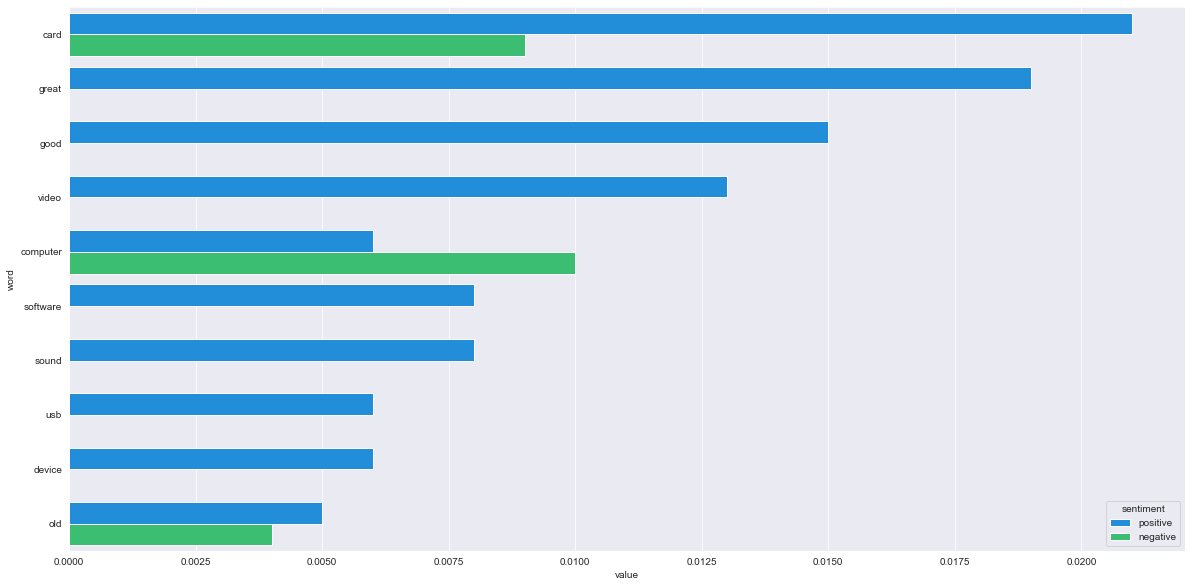

In [12]:
import seaborn as sns

df1 = pd.DataFrame(
    list(df["S0-T0"].apply(get_word_weight)), columns=["word", "positive"]
)
df2 = pd.DataFrame(
    list(df["S1-T0"].apply(get_word_weight)), columns=["word", "negative"]
)

df_tot = pd.merge(df1, df2, on="word", how="left")
df_tot.sort_values(by="positive", ascending=False, inplace=True)
df_tot = df_tot[:10]

df_tot.set_index("word", inplace=True)
df_tot = df_tot.rename_axis(columns=["sentiment"]).stack().rename("value")
df_tot = df_tot.reset_index()

df_tot.sort_values(by="value", ascending=False, inplace=True)
df_tot = df_tot[:20]

fig = plt.figure(figsize=(20, 10))
sns.barplot(
    y=df_tot["word"],
    x=df_tot["value"],
    hue=df_tot["sentiment"],
    dodge=True,
    palette=sns.color_palette("terrain"),
)

<AxesSubplot:ylabel='sentiment'>

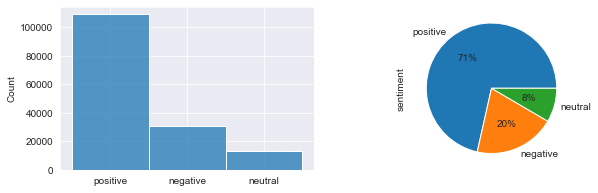

In [13]:
from matplotlib import colors
import seaborn as sns

pi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Pi.csv", header=None)

doc_sentiment = pi_df.idxmax(axis=1).map(lambda x: "positive" if x == 0 else "negative")
doc_sentiment.loc[pi_df[0] == 0.5] = "neutral"

reviews_df["sentiment"] = doc_sentiment

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(x=doc_sentiment, ax=axes[0])

counts = doc_sentiment.value_counts()
counts.plot(
    ax=axes[1],
    kind="pie",
    ylabel='sentiment',
    #colors=sns.color_palette("pastel")[0:7],
    autopct="%.0f%%",
)

In [14]:
theta_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Theta.csv")
theta_df.drop(columns=["Unnamed: 10"], inplace=True)

mask = theta_df >= 0.3
mask = mask.apply(lambda x: list(mask.columns[x]), axis=1)

reviews_df["topics"] = mask.apply(lambda x: list(map(map_topic_sentiment, x)))

In [15]:
reviews_df.to_json(asum_output_dir / "topics.json", orient="records")

In [16]:
phi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Phi.csv")
phi_df.sort_values(by="S1-T1", ascending=False, inplace=True)
phi_df["S1-T1"]

43140    0.026211
1150     0.021364
35585    0.019247
38176    0.017000
21583    0.013835
           ...   
24212    0.000000
44741    0.000000
36160    0.000000
30189    0.000000
38858    0.000000
Name: S1-T1, Length: 50297, dtype: float64

### WordClouds by Topic
- most common words per topic (positive, negative)

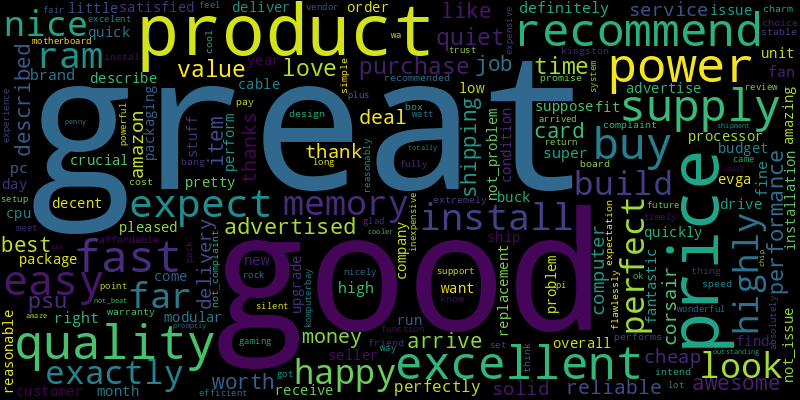

In [17]:
wc = WordCloud(height=400, width=800)
wc.generate_from_frequencies(
    dict(zip(phi_df["Unnamed: 0"].values, phi_df["S0-T4"].values))
)
wc.to_image()

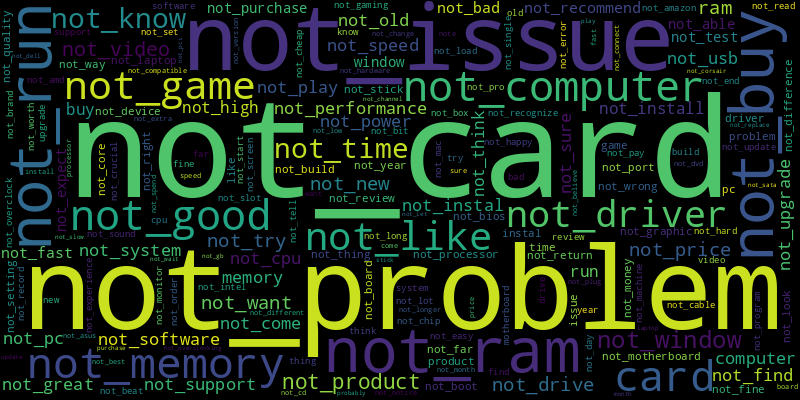

In [18]:
wc.generate_from_frequencies(
    dict(zip(phi_df["Unnamed: 0"].values, phi_df["S1-T4"].values))
)
wc.to_image()

In [19]:
theta_df

,S0-T0,S0-T1,S0-T2,S0-T3,S0-T4,S1-T0,S1-T1,S1-T2,S1-T3,S1-T4
0,0.784615,0.015385,0.015385,0.015385,0.169231,0.028571,0.028571,0.028571,0.028571,0.885714
1,0.840000,0.040000,0.040000,0.040000,0.040000,0.314286,0.028571,0.028571,0.028571,0.600000
2,0.938462,0.015385,0.015385,0.015385,0.015385,0.200000,0.200000,0.200000,0.200000,0.200000
3,0.885714,0.028571,0.028571,0.028571,0.028571,0.028571,0.600000,0.028571,0.028571,0.314286
4,0.200000,0.200000,0.200000,0.200000,0.200000,0.466667,0.022222,0.022222,0.022222,0.466667
...,...,...,...,...,...,...,...,...,...,...
152363,0.015385,0.015385,0.784615,0.169231,0.015385,0.430303,0.006061,0.369697,0.187879,0.006061
152364,0.028571,0.028571,0.028571,0.028571,0.885714,0.200000,0.200000,0.200000,0.200000,0.200000
152365,0.066667,0.066667,0.733333,0.066667,0.066667,0.200000,0.200000,0.200000,0.200000,0.200000
152366,0.040000,0.040000,0.840000,0.040000,0.040000,0.040000,0.040000,0.440000,0.040000,0.440000


In [20]:
pi_df

,0,1
0,0.636364,0.363636
1,0.428571,0.571429
2,0.875000,0.125000
3,0.500000,0.500000
4,0.166667,0.833333
...,...,...
152363,0.291667,0.708333
152364,0.800000,0.200000
152365,0.666667,0.333333
152366,0.500000,0.500000


In [21]:
phi_df.sort_values("S1-T1", ascending=False)

,Unnamed: 0,S0-T0,S0-T1,S0-T2,S0-T3,S0-T4,S1-T0,S1-T1,S1-T2,S1-T3,S1-T4
43140,card,0.021439,0.002017,0.001608,0.023711,4.868353e-03,0.009085,0.026211,0.003011,0.007744,0.006083
1150,driver,0.003999,0.000110,0.000045,0.000654,4.010172e-09,0.000312,0.021364,0.000063,0.000429,0.001873
35585,drive,0.004265,0.001897,0.001057,0.001178,2.109355e-03,0.001283,0.019247,0.000694,0.004233,0.001454
38176,window,0.005253,0.005289,0.000363,0.001366,4.010172e-09,0.000758,0.017000,0.000118,0.000194,0.002235
21583,usb,0.005841,0.000300,0.000675,0.000266,9.223797e-05,0.000230,0.013835,0.000513,0.003165,0.000809
...,...,...,...,...,...,...,...,...,...,...,...
25687,nice,0.004138,0.001918,0.011403,0.002824,8.666383e-03,0.000000,0.000000,0.000000,0.000000,0.000000
24412,attractive,0.000034,0.000003,0.000164,0.000049,1.046655e-04,0.000000,0.000000,0.000000,0.000000,0.000000
13608,love,0.002373,0.001580,0.003338,0.002634,6.909928e-03,0.000000,0.000000,0.000000,0.000000,0.000000
43135,fortunate,0.000025,0.000026,0.000006,0.000008,4.010172e-07,0.000000,0.000000,0.000000,0.000000,0.000000


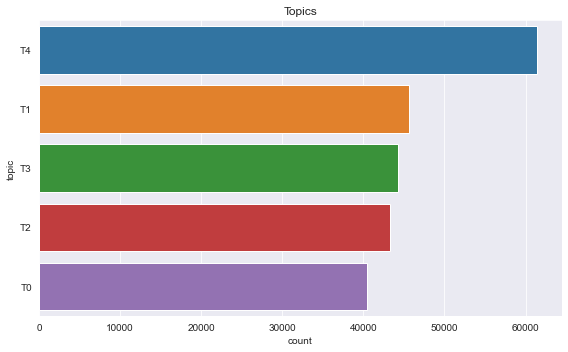

In [22]:
count = Counter()

for x in reviews_df["topics"].values:
    topics = set(["T" + str(y["topic"]) for y in x])
    count.update(topics)

topics_count = pd.DataFrame(count.items(), columns=["topic", "count"])
topics_count["topic"] = topics_count["topic"].astype("category")

order = topics_count.sort_values(by="count", ascending=False).topic
fig = plt.figure(figsize=(8, 5))
ax = sns.barplot(
    y=topics_count["topic"], x=topics_count["count"], order=order, orient="h"
)
ax.set_title("Topics")
fig.tight_layout()

#### Filtrare i topic-sentiment classificando il sentiment

- T1-S0: 34, T1-S1: 56 ---> S1
- T1-S0: 74, T1-S1: 21 ---> S0
- T1-S0: 67, T1-S1: 67 ---> S2 (neutral?)

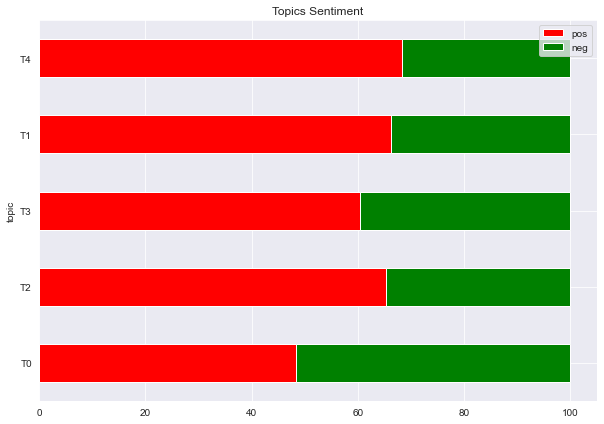

In [23]:
from matplotlib.pyplot import title


pos_count = Counter()
neg_count = Counter()

for x in reviews_df["topics"].values:
    pos_topics = set(["T" + str(st["topic"]) for st in x if st["sentiment"] == 0])
    neg_topics = set(["T" + str(st["topic"]) for st in x if st["sentiment"] == 1])

    pos_count.update(pos_topics)
    neg_count.update(neg_topics)


pos_df = pd.DataFrame(pos_count.items(), columns=["topic", "pos"])
neg_df = pd.DataFrame(neg_count.items(), columns=["topic", "neg"])

st_counts = pd.merge(pos_df, neg_df, on="topic")
st_counts["topic"] = st_counts["topic"].astype("category")

total = st_counts["pos"] + st_counts["neg"]
st_counts["pos"] = st_counts["pos"] / total * 100
st_counts["neg"] = st_counts["neg"] / total * 100

st_counts.set_index("topic", inplace=True)
st_counts.sort_index(inplace=True)
st_counts = st_counts.iloc[[int(o[1]) for o in order][::-1]]

fig, ax = plt.subplots(figsize=(10, 7))
st_counts.plot(kind="barh", stacked=True, color=["red", "green"], ax=ax, title="Topics Sentiment")

pass

### topic sentiment over time

In [24]:
timestamps = list(set(reviews_df['timestamp'])) # discretizzare per anni
count = Counter()

for x in reviews_df["topics"].values:
    for t in timestamps:
        topics = set(["T" + str(y["topic"]) + str(t) for y in x])
        count.update(topics)

topics_count = pd.DataFrame(count.items(), columns=["topic", "count"])

KeyboardInterrupt: 

In [ ]:
len(timestamps)

### positive sentiment over time

In [ ]:
X = reviews_df.copy()
X = X.loc[X["sentiment"] == "positive"]
fig = plt.figure(figsize=(20, 4))
sns.histplot(x=X["timestamp"], hue=X["sentiment"])

### negative sentiment over time

In [ ]:
X = reviews_df.copy()
X = X.loc[X["sentiment"] == "negative"]
fig = plt.figure(figsize=(20, 4))
sns.histplot(x=X["timestamp"], hue=X["sentiment"])

### top 30 brands sentiment 

In [ ]:
X = reviews_df.copy()

# take only top 30 most common brands
most_common_brands = pd.DataFrame(Counter(X["brand"]).most_common(30))
X = X.loc[X["brand"].isin(set(most_common_brands[0]))]

fig, ax = plt.subplots(figsize=(20, 7))

x = (
    X.groupby("brand")["sentiment"]
    .value_counts()
    .rename_axis(["brand", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="brand", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="brand", kind="bar", stacked=True, ax=ax)
fig.tight_layout()


### sentiment per category 

In [ ]:
X = reviews_df.copy()

fig, ax = plt.subplots(figsize=(20, 7))

x = (
    X.groupby("category")["sentiment"]
    .value_counts()
    .rename_axis(["category", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="category", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="category", kind="bar", stacked=True, ax=ax)
fig.tight_layout()

### sentiment per price

In [ ]:
X = reviews_df.copy()
price_categories = pd.CategoricalDtype(
    categories=[
        "Under \$25",
        "\$25 to \$50",
        "\$50 to \$100",
        "\$100 to \$200",
        "\$200 & Above",
    ],
    ordered=True,
)


X["price"] = X["price"].apply(
    lambda x: "Under \$25"
    if x < 25
    else (
        "\$25 to \$50"
        if x < 50
        else (
            "\$50 to \$100"
            if x < 100
            else ("\$100 to \$200" if x < 200 else "\$200 & Above")
        )
    )
)
X["price"]=X["price"].astype(price_categories)

fig, ax = plt.subplots(figsize=(10, 7))

x = (
    X.groupby("price")["sentiment"]
    .value_counts()
    .rename_axis(["price", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="price", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="price", kind="bar", stacked=True, ax=ax)
fig.tight_layout()

### EVALUATION

In [ ]:
t = pd.crosstab(
    reviews_df["overall"].apply(
        lambda x: "negative" if x < 3 else ("neutral" if x == 3 else "positive")
    ),
    reviews_df["sentiment"].astype("category"),
)
t

### negative sentiment over time

In [ ]:
X = reviews_df.copy()
X = X.loc[X["sentiment"] == "negative"]
fig = plt.figure(figsize=(20, 4))
sns.histplot(x=X["timestamp"], hue=X["sentiment"])

### top 30 brands sentiment 

In [ ]:
X = reviews_df.copy()

# take only top 30 most common brands
most_common_brands = pd.DataFrame(Counter(X["brand"]).most_common(30))
X = X.loc[X["brand"].isin(set(most_common_brands[0]))]

fig, ax = plt.subplots(figsize=(20, 7))

x = (
    X.groupby("brand")["sentiment"]
    .value_counts()
    .rename_axis(["brand", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="brand", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="brand", kind="bar", stacked=True, ax=ax)
fig.tight_layout()


### sentiment per category 

In [ ]:
X = reviews_df.copy()

fig, ax = plt.subplots(figsize=(20, 7))

x = (
    X.groupby("category")["sentiment"]
    .value_counts()
    .rename_axis(["category", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="category", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="category", kind="bar", stacked=True, ax=ax)
fig.tight_layout()

### sentiment per price

In [ ]:
X = reviews_df.copy()
price_categories = pd.CategoricalDtype(
    categories=[
        "Under \$25",
        "\$25 to \$50",
        "\$50 to \$100",
        "\$100 to \$200",
        "\$200 & Above",
    ],
    ordered=True,
)


X["price"] = X["price"].apply(
    lambda x: "Under \$25"
    if x < 25
    else (
        "\$25 to \$50"
        if x < 50
        else (
            "\$50 to \$100"
            if x < 100
            else ("\$100 to \$200" if x < 200 else "\$200 & Above")
        )
    )
)
X["price"]=X["price"].astype(price_categories)

fig, ax = plt.subplots(figsize=(10, 7))

x = (
    X.groupby("price")["sentiment"]
    .value_counts()
    .rename_axis(["price", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="price", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="price", kind="bar", stacked=True, ax=ax)
fig.tight_layout()

### EVALUATION

In [ ]:
t = pd.crosstab(
    reviews_df["overall"].apply(
        lambda x: "negative" if x < 3 else ("neutral" if x == 3 else "positive")
    ),
    reviews_df["sentiment"].astype("category"),
)

In [ ]:
import numpy as np

cm = t.to_numpy()
np.sum(cm.diagonal()) / np.sum(cm)